# Attacks on Neural Networks in a Lightweight Speech Pseudonymization Pipeline

## Imports

In [26]:
import ASR_2024_anonymization_module_learning.speaker_anonymization as pipeline
import ASR_2024_anonymization_module_learning.speaker_anonymization.optimize as pipeline_optimize

import util
from backdoored_dataset import BackdooredVCTK, CachedVCTK
from attacks.jingleback import JingleBack
from attacks.evasion_attack import EvasionAttack
from attacks.fgsm import FGSM
from attacks.pgd import PGD
from metrics import attack_success_rate, clean_accuracy_drop

import os
import gc
import warnings

import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader

## Preparation

In [33]:
pipeline_config_train = pipeline.config.Config(
    num_trials=5,
    n_speakers=10,
    n_samples_per_speaker=10,
    gender=None,
    min_age=None,
    max_age=None,
    accent=None,
    region=None
)

pipeline_config_test = pipeline.config.Config(
    num_trials=1,
    n_speakers=10,
    n_samples_per_speaker=100,
    gender=None,
    min_age=None,
    max_age=None,
    accent=None,
    region=None
)

os.makedirs(pipeline_config_train.BACKDOORED_FOLDER, exist_ok=True)
os.makedirs(os.path.join(pipeline_config_train.BACKDOORED_FOLDER, "train"), exist_ok=True)
os.makedirs(os.path.join(pipeline_config_train.BACKDOORED_FOLDER, "test"), exist_ok=True)
os.makedirs("d:/Datasets/vctk/perturbed_audio/fgsm", exist_ok=True)
os.makedirs("d:/Datasets/vctk/perturbed_audio/pgd", exist_ok=True)

warnings.filterwarnings("ignore")

util.set_global_seed(3131)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if str(device) == "cuda":
    print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce GTX 1050


## Creating Clean and Backdoored Test Datasets

In [3]:
clean_test_set = CachedVCTK(pipeline_config_test)


TARGET_SPEAKER_ID = 0
jingleback_attack = JingleBack(source_label=None, target_label=TARGET_SPEAKER_ID)

backdoored_test_set = BackdooredVCTK(jingleback_attack, poisoning_rate=1.0, train=False, pipeline_config=pipeline_config_test)
backdoored_test_loader = DataLoader(backdoored_test_set, batch_size=1, shuffle=False)

2024-06-06 20:23:40,521 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_100_None_None_None_None_None.pkl
2024-06-06 20:23:58,053 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_100_None_None_None_None_None.pkl


## Assessing the Clean Models

2024-06-06 20:24:53,519 - INFO - 

Starting audio effects optimization...


2024-06-06 20:24:53,520 - INFO - Loading data...

2024-06-06 20:24:53,523 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl
2024-06-06 20:24:53,537 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Mean loss: 6.914008729768612
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


Mean loss: 7.184524281732738
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 5.6201104599470275
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


Mean loss: 4.698209332586266
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 4.296257262012295
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 3.8696772436593894
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 3.9817274728079792
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 4.165274001811049
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


Mean loss: 2.9484489253419452
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 2.604839147208841
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 2.446262659211643
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 2.0121374841453505
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 2.065704097043199
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 2.337811812433902
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 1.8671789913919201
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.746745342232898
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.369100203802809
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.4579400964228444
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.5890775127572123
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.3625167983648316
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 1.316040847250224
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.1703123521086853
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.035792442288472
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 1.060189553037062
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 1.0327933128601217
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.0167040531655016
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 0.9774647765890176
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Mean loss: 1.1990510021131866
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


Mean loss: 0.8321331104659475
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


Mean loss: 1.1553438427282707


2024-06-06 20:42:07,845 - INFO - Speaker Identification model trained.


2024-06-06 20:42:07,846 - INFO - Evaluating the initial models...



Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-06 20:44:25,413 - INFO - Evaluation complete.

2024-06-06 20:44:25,413 - INFO - Average WER: 0.10402849927849928

2024-06-06 20:44:25,414 - INFO - Speaker Verification Accuracy: 0.62

2024-06-06 20:44:25,415 - INFO - Combined Loss: 0.36201424963924966



100%|██████████| 1000/1000 [01:00<00:00, 16.53it/s]


WER: 0.10402849927849928
ASV Acc: 0.62
ASV ASR: 0.18


RuntimeError: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

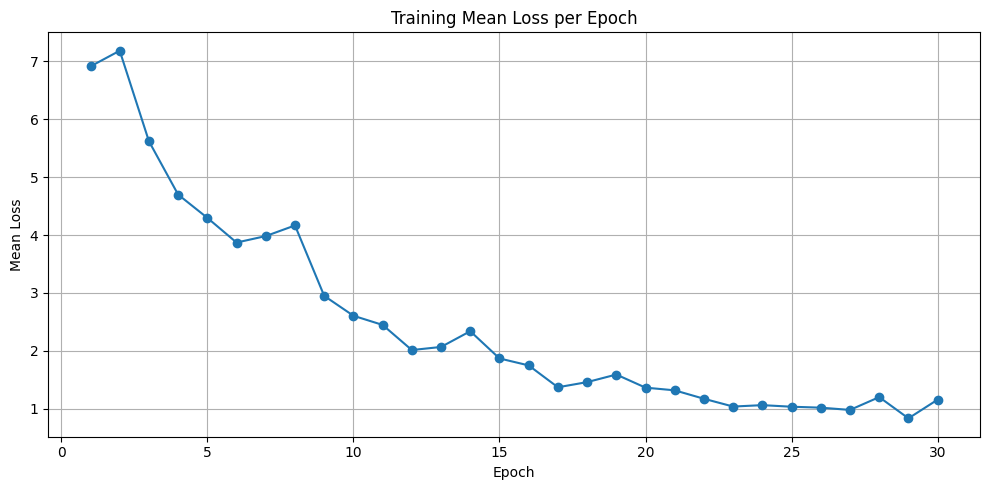

In [4]:
clean_asr_processor, clean_asr_model, clean_asv_model, clean_wer, clean_asv_acc, _ = pipeline_optimize.optimize_audio_effects(pipeline_config_train, stop_after_model_evaluation=True)
clean_asv_asr, _ = attack_success_rate(clean_asv_model, backdoored_test_loader, target_label=TARGET_SPEAKER_ID, device=device)

print("WER:", clean_wer)
print("ASV Acc:", clean_asv_acc)
print("ASV ASR:", clean_asv_asr)

## Assessing Backdoored Models

2024-06-05 16:40:07,019 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl
2024-06-05 16:40:12,876 - INFO - 

Starting audio effects optimization...


2024-06-05 16:40:12,878 - INFO - Loading data...

2024-06-05 16:40:12,879 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


Mean loss: 2.9240824485570194
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Mean loss: 1.7833980977535249
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Mean loss: 1.2140693283267319
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


Mean loss: 1.0691707641561516
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Mean loss: 0.963664273446193
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


Mean loss: 0.6997362927626818
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Mean loss: 0.6284384146833326
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Mean loss: 0.5805279437146237
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


Mean loss: 0.551515465695411
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Mean loss: 0.44091646977060006
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Mean loss: 0.3586736269576795
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Mean loss: 0.40053841570246734
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Mean loss: 0.36494787284114866
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Mean loss: 0.24289519189333078
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Mean loss: 0.2635956320577998
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Mean loss: 0.2249732600480638
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Mean loss: 0.1841836796870848
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Mean loss: 0.26432623314081866
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Mean loss: 0.19572154174795287
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


Mean loss: 0.20635923736872883
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


Mean loss: 0.14477386605009088
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


Mean loss: 0.12565020673944674
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Mean loss: 0.16032756281420915
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Mean loss: 0.10736360141804653
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Mean loss: 0.3278785911659952
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


Mean loss: 0.11919711167776313
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Mean loss: 0.22645807687520006
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Mean loss: 0.12872529946507258
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


Mean loss: 0.12535319781750331
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]
2024-06-05 16:43:30,398 - INFO - Speaker Identification model trained.


2024-06-05 16:43:30,399 - INFO - Evaluating the initial models...



Mean loss: 0.13744491552262844
Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 16:45:43,958 - INFO - Evaluation complete.

2024-06-05 16:45:43,959 - INFO - Average WER: 0.10680627705627703

2024-06-05 16:45:43,960 - INFO - Speaker Verification Accuracy: 0.9

2024-06-05 16:45:43,961 - INFO - Combined Loss: 0.5034031385281386



100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]
2024-06-05 16:48:28,273 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl


Poisoning Rate: 0.05
    ASR Word Error Rate: 0.10680627705627703
    ASR Word Error Rate Increase: 0.002777777777777754
    ASV Accuracy: 0.9
    ASV Attack Success Rate: (0.9544444444444444, 0)
    ASV Clean Accuracy Drop: -0.22


2024-06-05 16:48:32,752 - INFO - 

Starting audio effects optimization...


2024-06-05 16:48:32,753 - INFO - Loading data...

2024-06-05 16:48:32,754 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Somebody433/fine-tuned-vctkdataset and are newly init

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


Mean loss: 3.326254883108195
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Mean loss: 1.8583809582330286
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


Mean loss: 1.5739447435736655
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


Mean loss: 1.2748821472283454
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Mean loss: 1.0440515780961142
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


Mean loss: 0.7897837562928908
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Mean loss: 0.7169178559338616
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Mean loss: 0.59107926733559
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


Mean loss: 0.5576220014845603
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Mean loss: 0.38268843456404283
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Mean loss: 0.32038254715909714
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Mean loss: 0.37161426180959095
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Mean loss: 0.31991892239093433
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Mean loss: 0.26430939375580237
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Mean loss: 0.2683347736300493
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Mean loss: 0.31287690057376494
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Mean loss: 0.2001998412470857
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Mean loss: 0.13807129749435262
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Mean loss: 0.16187686524677702
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


Mean loss: 0.19542276063027203
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


Mean loss: 0.3769889845178545
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Mean loss: 0.16992399211675546
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Mean loss: 0.22990825732223982
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


Mean loss: 0.19086504858653824
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.66it/s]


Mean loss: 0.1071680355049375
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


Mean loss: 0.09307256745188852
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


Mean loss: 0.1301088059718583
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Mean loss: 0.23153612712060748
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Mean loss: 0.1902654675755531
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]
2024-06-05 16:51:50,354 - INFO - Speaker Identification model trained.




Mean loss: 0.3315103475603405
Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 16:51:50,355 - INFO - Evaluating the initial models...

2024-06-05 16:54:11,467 - INFO - Evaluation complete.

2024-06-05 16:54:11,468 - INFO - Average WER: 0.099786075036075

2024-06-05 16:54:11,469 - INFO - Speaker Verification Accuracy: 0.65

2024-06-05 16:54:11,470 - INFO - Combined Loss: 0.3748930375180375



100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]
2024-06-05 16:56:54,637 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl


Poisoning Rate: 0.1
    ASR Word Error Rate: 0.099786075036075
    ASR Word Error Rate Increase: -0.00424242424242427
    ASV Accuracy: 0.65
    ASV Attack Success Rate: (0.9155555555555556, 0)
    ASV Clean Accuracy Drop: 0.03


2024-06-05 16:57:00,611 - INFO - 

Starting audio effects optimization...


2024-06-05 16:57:00,612 - INFO - Loading data...

2024-06-05 16:57:00,613 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Somebody433/fine-tuned-vctkdataset and are newly init

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.29it/s]


Mean loss: 3.036103650316095
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


Mean loss: 1.4460296447225847
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Mean loss: 1.1678054518889984
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Mean loss: 0.9442168868500448
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Mean loss: 0.8131372365899733
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Mean loss: 0.6542413347023103
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Mean loss: 0.5166251310960797
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Mean loss: 0.3688580391817959
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


Mean loss: 0.42227110837779036
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Mean loss: 0.28588642336573683
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Mean loss: 0.3068141429350362
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Mean loss: 0.36486518999408873
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


Mean loss: 0.25619492355826423
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


Mean loss: 0.24183453622911885
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Mean loss: 0.25178503603601654
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


Mean loss: 0.2219836737902733
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:05<00:00, 16.71it/s]


Mean loss: 0.207728182776209
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


Mean loss: 0.25218272498186706
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


Mean loss: 0.20191988518753534
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


Mean loss: 0.32406128682804336
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Mean loss: 0.1858091059042021
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


Mean loss: 0.13601451345823307
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Mean loss: 0.22081913460538088
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


Mean loss: 0.17293148880274173
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Mean loss: 0.15259453880527418
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Mean loss: 0.08844015320063356
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


Mean loss: 0.08127976444947706
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


Mean loss: 0.1040645122935058
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


Mean loss: 0.152342830092839
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s]
2024-06-05 17:00:17,037 - INFO - Speaker Identification model trained.


2024-06-05 17:00:17,038 - INFO - Evaluating the initial models...



Mean loss: 0.15512104032423957
Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 17:02:30,778 - INFO - Evaluation complete.

2024-06-05 17:02:30,778 - INFO - Average WER: 0.10018326118326117

2024-06-05 17:02:30,779 - INFO - Speaker Verification Accuracy: 0.82

2024-06-05 17:02:30,780 - INFO - Combined Loss: 0.46009163059163055



100%|██████████| 1000/1000 [00:54<00:00, 18.47it/s]
2024-06-05 17:05:11,293 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl


Poisoning Rate: 0.2
    ASR Word Error Rate: 0.10018326118326117
    ASR Word Error Rate Increase: -0.00384523809523811
    ASV Accuracy: 0.82
    ASV Attack Success Rate: (0.9833333333333333, 0)
    ASV Clean Accuracy Drop: -0.08


2024-06-05 17:05:16,201 - INFO - 

Starting audio effects optimization...


2024-06-05 17:05:16,202 - INFO - Loading data...

2024-06-05 17:05:16,203 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Somebody433/fine-tuned-vctkdataset and are newly init

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


Mean loss: 3.238864331070616
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Mean loss: 1.8629378312000335
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


Mean loss: 1.3974268954166928
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Mean loss: 1.0758454652776164
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


Mean loss: 0.7794273973859527
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Mean loss: 0.6705770266828404
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Mean loss: 0.6312930296360537
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


Mean loss: 0.4281482715818947
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Mean loss: 0.43782410331837585
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


Mean loss: 0.38440787937428467
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Mean loss: 0.28073458654589556
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Mean loss: 0.323275637145739
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Mean loss: 0.27245772120247014
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


Mean loss: 0.3706116650126188
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


Mean loss: 0.2322179171365633
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Mean loss: 0.2185718552926619
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Mean loss: 0.24750345670987473
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Mean loss: 0.16341936006778668
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Mean loss: 0.2008427818345379
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Mean loss: 0.12261948229918232
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


Mean loss: 0.1623767324020808
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Mean loss: 0.12820874128518284
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Mean loss: 0.10394743626531294
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Mean loss: 0.09656094696378431
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Mean loss: 0.16601432968305738
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Mean loss: 0.2316915734747613
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Mean loss: 0.08396639678030623
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Mean loss: 0.08122886886430479
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Mean loss: 0.06799500625598817
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]
2024-06-05 17:08:28,866 - INFO - Speaker Identification model trained.


2024-06-05 17:08:28,867 - INFO - Evaluating the initial models...



Mean loss: 0.06737556754197385
Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 17:10:44,557 - INFO - Evaluation complete.

2024-06-05 17:10:44,557 - INFO - Average WER: 0.10550072150072148

2024-06-05 17:10:44,558 - INFO - Speaker Verification Accuracy: 0.88

2024-06-05 17:10:44,558 - INFO - Combined Loss: 0.4927503607503607



100%|██████████| 1000/1000 [00:54<00:00, 18.23it/s]
2024-06-05 17:13:24,131 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl


Poisoning Rate: 0.3
    ASR Word Error Rate: 0.10550072150072148
    ASR Word Error Rate Increase: 0.0014722222222222081
    ASV Accuracy: 0.88
    ASV Attack Success Rate: (0.9866666666666667, 0)
    ASV Clean Accuracy Drop: -0.11


2024-06-05 17:13:28,895 - INFO - 

Starting audio effects optimization...


2024-06-05 17:13:28,895 - INFO - Loading data...

2024-06-05 17:13:28,896 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Somebody433/fine-tuned-vctkdataset and are newly init

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:07<00:00, 14.20it/s]


Mean loss: 3.1152564140881
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


Mean loss: 1.801502548765692
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.77it/s]


Mean loss: 1.0320354653530466
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Mean loss: 0.892506141192207
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


Mean loss: 0.725576408091365
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Mean loss: 0.6082494301128463
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Mean loss: 0.6528239645620124
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Mean loss: 0.3952737515435001
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Mean loss: 0.4524077448421099
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Mean loss: 0.40392656158193857
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Mean loss: 0.3127368799757534
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Mean loss: 0.19397373206952806
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


Mean loss: 0.2677731170322943
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


Mean loss: 0.20875015789016715
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


Mean loss: 0.1340016071172272
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


Mean loss: 0.14397124238939057
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.77it/s]


Mean loss: 0.09165541139433231
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Mean loss: 0.14921946474408543
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


Mean loss: 0.1371598860900184
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


Mean loss: 0.21998196363176348
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


Mean loss: 0.12654445616744447
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Mean loss: 0.0847938368098292
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.78it/s]


Mean loss: 0.11119806436877411
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


Mean loss: 0.15258047818438847
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Mean loss: 0.052982806276680706
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Mean loss: 0.104450293547647
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Mean loss: 0.15416962542559895
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


Mean loss: 0.061358485824110645
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Mean loss: 0.13595269709527089
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]
2024-06-05 17:16:42,260 - INFO - Speaker Identification model trained.




Mean loss: 0.13897068927069214
Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 17:16:42,260 - INFO - Evaluating the initial models...

2024-06-05 17:19:03,789 - INFO - Evaluation complete.

2024-06-05 17:19:03,790 - INFO - Average WER: 0.10719516594516591

2024-06-05 17:19:03,790 - INFO - Speaker Verification Accuracy: 0.85

2024-06-05 17:19:03,791 - INFO - Combined Loss: 0.4785975829725829



100%|██████████| 1000/1000 [00:56<00:00, 17.66it/s]
2024-06-05 17:21:45,627 - INFO - Loading data from cache: d:/Datasets/vctk/cache\cache_10_10_None_None_None_None_None.pkl


Poisoning Rate: 0.4
    ASR Word Error Rate: 0.10719516594516591
    ASR Word Error Rate Increase: 0.003166666666666637
    ASV Accuracy: 0.85
    ASV Attack Success Rate: (0.98, 0)
    ASV Clean Accuracy Drop: -0.03


2024-06-05 17:21:50,700 - INFO - 

Starting audio effects optimization...


2024-06-05 17:21:50,700 - INFO - Loading data...

2024-06-05 17:21:50,701 - INFO - Loading ASR model...

Some weights of the model checkpoint at Somebody433/fine-tuned-vctkdataset were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Somebody433/fine-tuned-vctkdataset and are newly init

Initialized model with 10 speakers for fine-tuning.
Starting epoch 1/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.32it/s]


Mean loss: 2.7729227112588917
Starting epoch 2/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


Mean loss: 1.870857972831459
Starting epoch 3/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Mean loss: 1.207099213657857
Starting epoch 4/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Mean loss: 0.9139785345413839
Starting epoch 5/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Mean loss: 0.7760238365964233
Starting epoch 6/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


Mean loss: 0.6790012358709486
Starting epoch 7/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Mean loss: 0.4324156042023424
Starting epoch 8/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Mean loss: 0.2951259752207852
Starting epoch 9/30


Training: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]


Mean loss: 0.3239733859032776
Starting epoch 10/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Mean loss: 0.33869592994277353
Starting epoch 11/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Mean loss: 0.3381711269315201
Starting epoch 12/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Mean loss: 0.32740888998348966
Starting epoch 13/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Mean loss: 0.39283876155521275
Starting epoch 14/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


Mean loss: 0.24688022578092841
Starting epoch 15/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


Mean loss: 0.3607780668316238
Starting epoch 16/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Mean loss: 0.18146542752539738
Starting epoch 17/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


Mean loss: 0.12921024858565688
Starting epoch 18/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Mean loss: 0.2109851829768511
Starting epoch 19/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Mean loss: 0.11637040833188045
Starting epoch 20/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


Mean loss: 0.17015830891497502
Starting epoch 21/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Mean loss: 0.09937111366172587
Starting epoch 22/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Mean loss: 0.052904212362184
Starting epoch 23/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Mean loss: 0.026536858379924054
Starting epoch 24/30


Training: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Mean loss: 0.046668711333465965
Starting epoch 25/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Mean loss: 0.1338792423057553
Starting epoch 26/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Mean loss: 0.10066465383940042
Starting epoch 27/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Mean loss: 0.09445751799981451
Starting epoch 28/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


Mean loss: 0.06037454256100297
Starting epoch 29/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.66it/s]


Mean loss: 0.02589324158796835
Starting epoch 30/30


Training: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Mean loss: 0.01832694423073505


2024-06-05 17:25:08,334 - INFO - Speaker Identification model trained.


2024-06-05 17:25:08,334 - INFO - Evaluating the initial models...



Loss plot saved to ASR_2024_anonymization_module_learning/images/n_speakers-10_n_samples_per_speaker-10/speaker_verification_training_30_10_0.01/mean_losses_per_epoch.png


2024-06-05 17:27:20,156 - INFO - Evaluation complete.

2024-06-05 17:27:20,157 - INFO - Average WER: 0.1030797258297258

2024-06-05 17:27:20,157 - INFO - Speaker Verification Accuracy: 0.93

2024-06-05 17:27:20,159 - INFO - Combined Loss: 0.516539862914863



100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


Poisoning Rate: 0.5
    ASR Word Error Rate: 0.1030797258297258
    ASR Word Error Rate Increase: -0.0009487734487734767
    ASV Accuracy: 0.93
    ASV Attack Success Rate: (1.0, 0)
    ASV Clean Accuracy Drop: 0.04


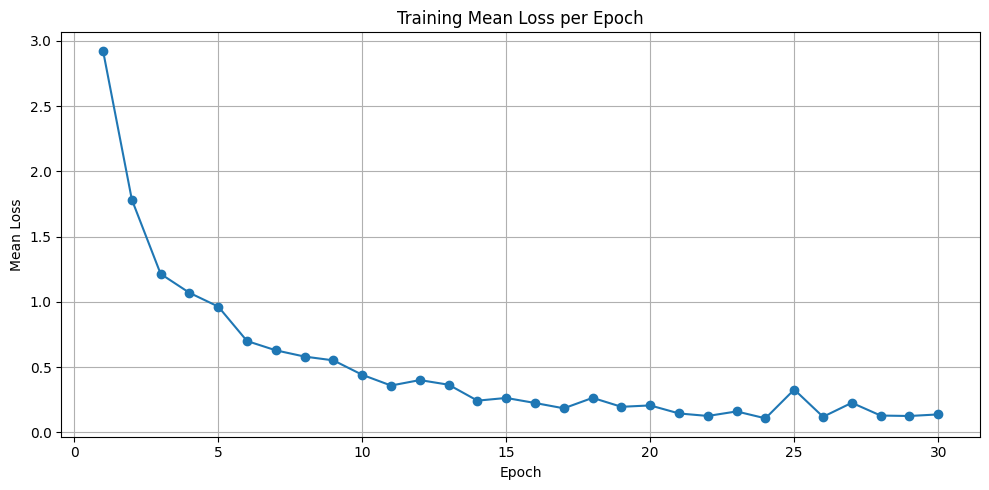

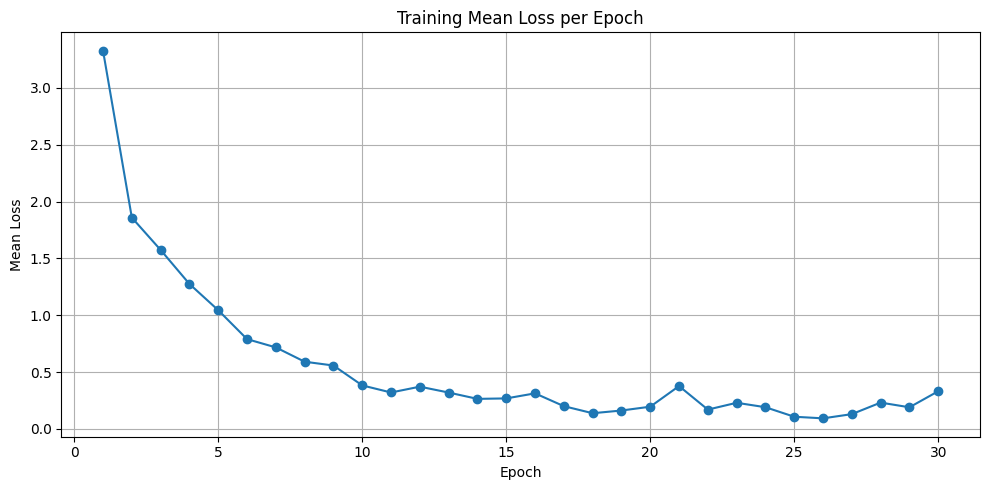

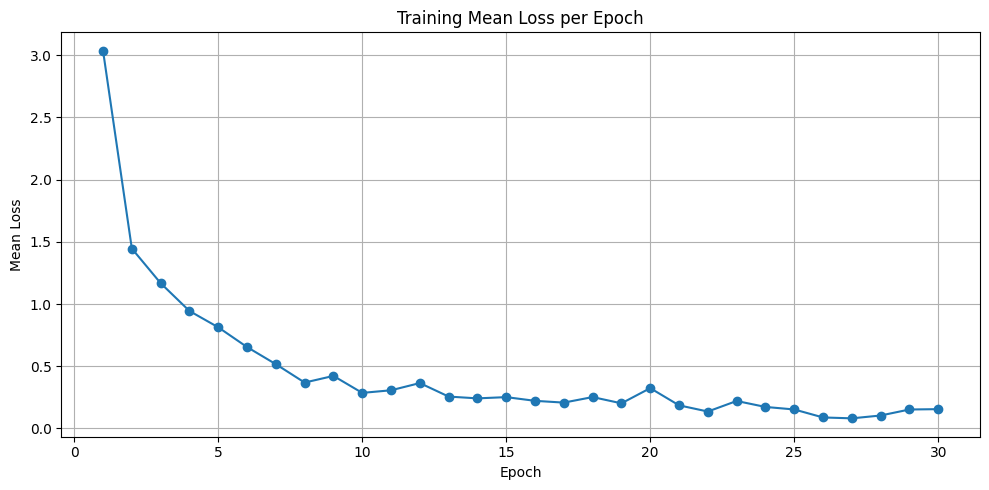

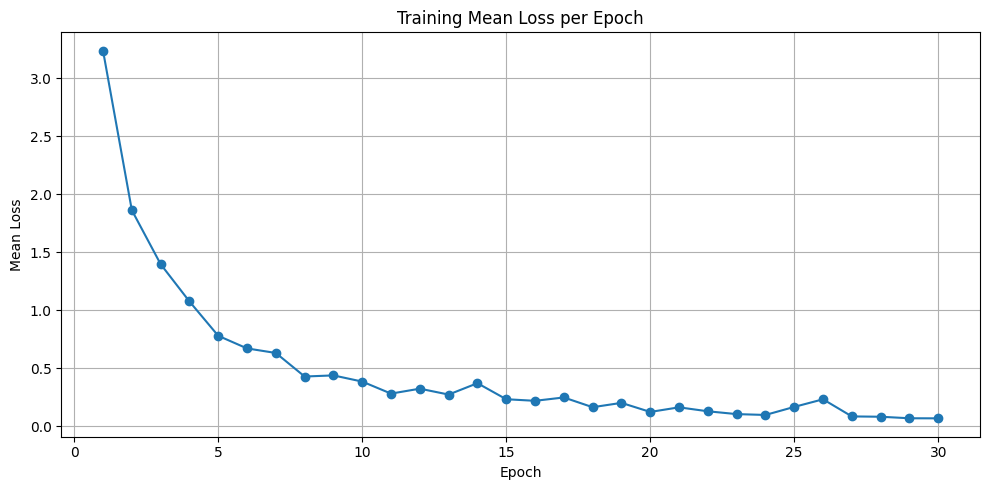

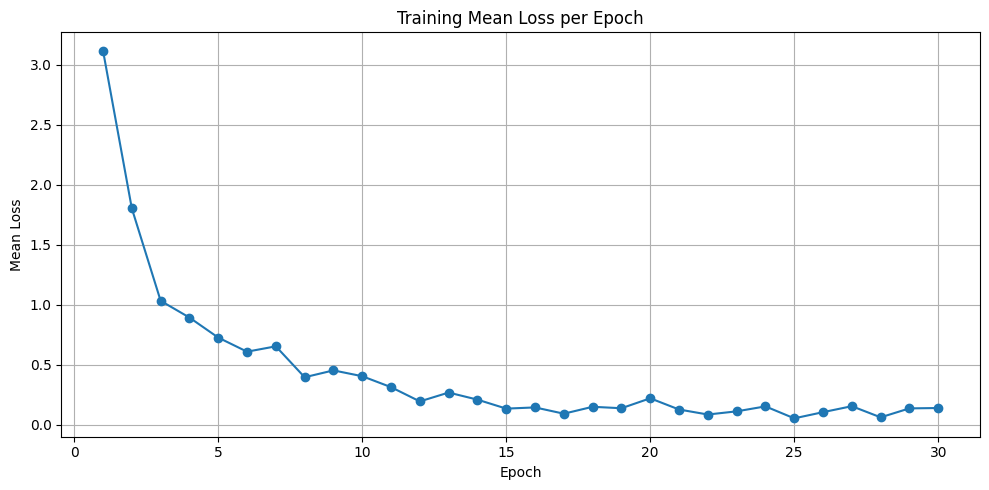

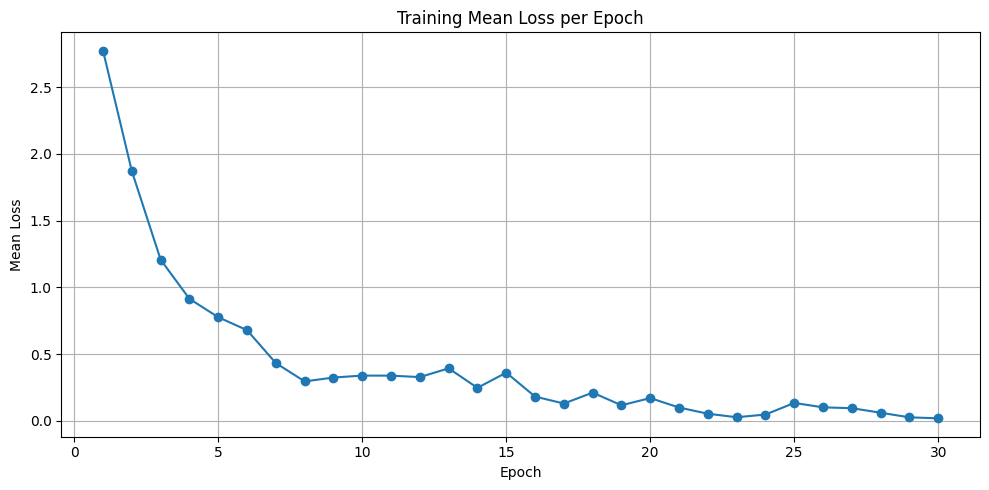

In [8]:
poisoning_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

asr_word_error_rates = []
asr_word_error_rate_increases = []
asv_accuracies = []
asv_attack_success_rates = []
asv_clean_accuracy_drops = []

for poisoning_rate in poisoning_rates:
    backdoored_train_set = BackdooredVCTK(jingleback_attack, poisoning_rate=poisoning_rate, train=True, pipeline_config=pipeline_config_train)
    backdoored_train_loader = DataLoader(backdoored_train_set, batch_size=1, shuffle=True)
    
    asr_processor, asr_model, asv_model, mean_wer, mean_asv_acc, _ = pipeline_optimize.optimize_audio_effects(pipeline_config_train, backdoored_vctk=backdoored_train_set, stop_after_model_evaluation=True)
    
    weri = mean_wer - clean_wer
    asr, _ = attack_success_rate(asv_model, backdoored_test_loader, target_label=TARGET_SPEAKER_ID, device=device)
    cad = clean_accuracy_drop(clean_asv_model, asv_model, clean_test_set)
    
    asr_word_error_rates.append(mean_wer)
    asr_word_error_rate_increases.append(weri)
    asv_accuracies.append(mean_asv_acc)
    asv_attack_success_rates.append(asr)
    asv_clean_accuracy_drops.append(cad)
    
    print("Poisoning Rate:", poisoning_rate)
    print("    ASR Word Error Rate:", mean_wer)
    print("    ASR Word Error Rate Increase:", weri)
    print("    ASV Accuracy:", mean_asv_acc)
    print("    ASV Attack Success Rate:", asr)
    print("    ASV Clean Accuracy Drop:", cad)

## Visualizing the Backdoor

,Poisoning Rate,Metric,Value
0,0.00,WER,0.104028
1,0.00,Acc,0.620000
2,0.00,ASR,0.180000
3,0.05,WER,0.106806
4,0.05,WERI,0.002778
5,0.05,Acc,0.900000
6,0.05,ASR,0.954444
7,0.05,CAD,-0.220000
8,0.10,WER,0.099786
9,0.10,WERI,-0.004242


2024-06-05 18:19:14,965 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 18:19:14,973 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Poisoning Rate', ylabel='Value'>

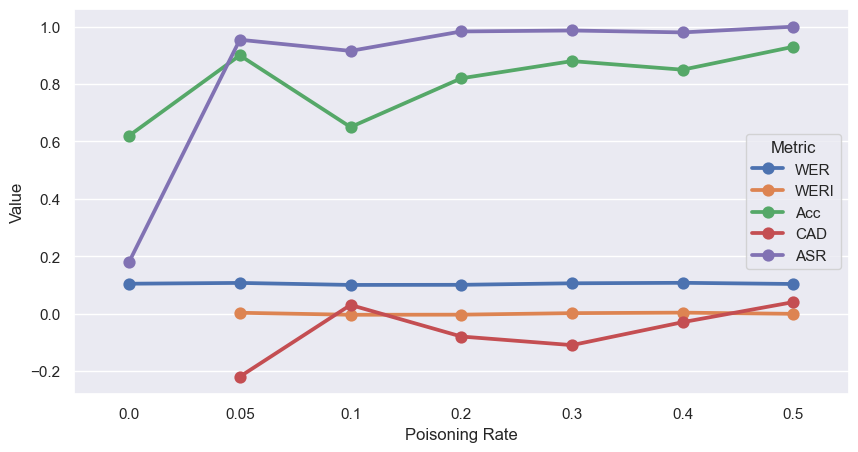

In [41]:
visualizations = []
visualizations.append([0, "WER", clean_wer])
visualizations.append([0, "Acc", clean_asv_acc])
visualizations.append([0, "ASR", clean_asv_asr])

for i in range(len(poisoning_rates)):
    visualizations.append([poisoning_rates[i], "WER", asr_word_error_rates[i]])
    visualizations.append([poisoning_rates[i], "WERI", asr_word_error_rate_increases[i]])
    visualizations.append([poisoning_rates[i], "Acc", asv_accuracies[i]])
    visualizations.append([poisoning_rates[i], "ASR", asv_attack_success_rates[i]])
    visualizations.append([poisoning_rates[i], "CAD", asv_clean_accuracy_drops[i]])
    
visualizations_df = pd.DataFrame(visualizations, columns=["Poisoning Rate", "Metric", "Value"])
display(visualizations_df)

sns.set_theme(rc={'figure.figsize':(10, 5)})
sns.pointplot(data=visualizations_df, x="Poisoning Rate", y="Value", hue="Metric", hue_order=["WER", "WERI", "Acc", "CAD", "ASR"])

## Assessing Evasion Attacks

In [35]:
clean_utterances, speaker_ids, transcriptions, _, _ = clean_test_set[:]

gc.collect()
torch.cuda.empty_cache()

### FGSM

In [40]:
from ASR_2024_anonymization_module_learning.speaker_anonymization.spi import SpeakerIdentificationModel

class FGSM(EvasionAttack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Taken from the Torchattacks (https://arxiv.org/abs/2010.01950) library and refactored."""

    def __init__(self, asv_model: SpeakerIdentificationModel, eps=8/255):
        super().__init__("FGSM", asv_model.model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]
        self.processor = asv_model.processor
        self.classifier = asv_model.classifier

    def forward(self, utterance, label):
        r"""
        Overridden.
        """
        
        gc.collect()
        torch.cuda.empty_cache()
        
        utterance = torch.unsqueeze(utterance, dim=0)
        utterance = utterance.to(self.device)
        utterance.requires_grad = True
        
        model_input = self.processor(utterance, sampling_rate=16000, return_tensors="pt").data["input_values"]
        model_input = model_input.squeeze(0).to(self.device)
        model_input.requires_grad = True
        
        model_output = self.model(model_input)
        model_output = model_output.last_hidden_state.mean(dim=1).to(device)
        model_output = self.classifier(model_output)
                                
        # Calculate loss
        loss = nn.BCEWithLogitsLoss()
        
        labels = torch.full((1, model_output.size(dim=1)), TARGET_SPEAKER_ID, dtype=torch.float32)
        labels = labels.to(self.device)
        
        if self.targeted:
            cost = -loss(model_output, labels)
        else:
            cost = loss(model_output, labels)
                            
        # Update adversarial images
        grad = torch.autograd.grad(cost, model_input, retain_graph=False, create_graph=False)[0]

        adversarial_utterance = utterance + self.eps * grad.sign()
        adversarial_utterance = torch.clamp(adversarial_utterance, min=0, max=1).detach()

        return adversarial_utterance

fgsm = FGSM(clean_asv_model, eps=8/255)
fgsm.set_mode_targeted_by_label(quiet=True)

fgsm_utterances = []
for index, utterance in enumerate(clean_utterances):
    fgsm_utterance = fgsm(utterance, TARGET_SPEAKER_ID)
    fgsm_utterances.append(fgsm_utterance)
    
    utterance_file_name = f"index{index}_speaker{speaker_ids[index]}_fgsm_target{TARGET_SPEAKER_ID}.wav"
    utterance_file_path = "d:/Datasets/vctk/perturbed_audio/fgsm/" + utterance_file_name
    torchaudio.save(uri=utterance_file_path, src=fgsm_utterance.cpu(), sample_rate=16000)

predicted_transcriptions, predicted_speakers, fgsm_wer, fgsm_asv_acc, _ = pipeline_optimize.evaluate_asr_and_asv(
    audio_data=[(fgsm_utterance.squeeze().to(device), None) for fgsm_utterance in fgsm_utterances],
    transcriptions=transcriptions,
    speakers=speaker_ids,
    asr_processor=clean_asr_processor,
    asr_model=clean_asr_model,
    asv_model=clean_asv_model,
    CONFIG=pipeline_config_test
)

2024-06-06 22:32:04,537 - INFO - Evaluation complete.

2024-06-06 22:32:04,538 - INFO - Average WER: 0.7730701510434868

2024-06-06 22:32:04,539 - INFO - Speaker Verification Accuracy: 0.1

2024-06-06 22:32:04,540 - INFO - Combined Loss: 0.43653507552174337





NameError: name 'evasion_attack_success_rate' is not defined

### PGD

In [45]:
class PGD(EvasionAttack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Taken from the Torchattacks (https://arxiv.org/abs/2010.01950) library and refactored."""

    def __init__(self, asv_model: SpeakerIdentificationModel, eps=8/255, alpha=2/255, steps=10, random_start=True):
        super().__init__("FGSM", asv_model.model)
        self.eps = eps
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]
        self.processor = asv_model.processor
        self.classifier = asv_model.classifier

    def forward(self, utterance, label):
        r"""
        Overridden.
        """
        
        gc.collect()
        torch.cuda.empty_cache()
        
        utterance = torch.unsqueeze(utterance, dim=0)
        utterance = utterance.to(self.device)
        utterance.requires_grad = True
        
        model_input = self.processor(utterance, sampling_rate=16000, return_tensors="pt").data["input_values"]
        model_input = model_input.squeeze(0).to(self.device)
        model_input.requires_grad = True
        
        adversarial_utterance = utterance.clone().detach()
        adversarial_model_input = model_input.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adversarial_model_input = adversarial_model_input + torch.empty_like(adversarial_model_input).uniform_(-self.eps, self.eps)
            adversarial_model_input = torch.clamp(adversarial_model_input, min=0, max=1).detach()
        
        loss = nn.BCEWithLogitsLoss()
        
        for _ in range(self.steps):
            adversarial_model_input.requires_grad = True
            
            model_output = self.model(adversarial_model_input)
            model_output = model_output.last_hidden_state.mean(dim=1).to(device)
            model_output = self.classifier(model_output)
                                    
            # Calculate loss            
            labels = torch.full((1, model_output.size(dim=1)), TARGET_SPEAKER_ID, dtype=torch.float32)
            labels = labels.to(self.device)
            
            if self.targeted:
                cost = -loss(model_output, labels)
            else:
                cost = loss(model_output, labels)
                                
            # Update adversarial images
            grad = torch.autograd.grad(cost, adversarial_model_input, retain_graph=False, create_graph=False)[0]

            adversarial_utterance = adversarial_utterance.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adversarial_utterance - utterance, min=-self.eps, max=self.eps)
            adversarial_utterance = torch.clamp(utterance + delta, min=0, max=1).detach()

        return adversarial_utterance

pgd = PGD(clean_asv_model, eps=8/255, alpha=2/255, steps=10, random_start=True)
pgd.set_mode_targeted_by_label(quiet=True)

pgd_utterances = []
for index, utterance in enumerate(clean_utterances):
    pgd_utterance = pgd(utterance, TARGET_SPEAKER_ID)
    pgd_utterances.append(pgd_utterance)
    
    utterance_file_name = f"index{index}_speaker{speaker_ids[index]}_pgd_target{TARGET_SPEAKER_ID}.wav"
    utterance_file_path = "d:/Datasets/vctk/perturbed_audio/pgd/" + utterance_file_name
    torchaudio.save(uri=utterance_file_path, src=pgd_utterance.cpu(), sample_rate=16000)

predicted_transcriptions, predicted_speakers, pgd_wer, pgd_asv_acc, _ = pipeline_optimize.evaluate_asr_and_asv(
    audio_data=[(pgd_utterance.squeeze().to(device), None) for pgd_utterance in pgd_utterances],
    transcriptions=transcriptions,
    speakers=speaker_ids,
    asr_processor=clean_asr_processor,
    asr_model=clean_asr_model,
    asv_model=clean_asv_model,
    CONFIG=pipeline_config_test
)

2024-06-06 23:48:41,575 - INFO - Evaluation complete.

2024-06-06 23:48:41,577 - INFO - Average WER: 0.7631142503222605

2024-06-06 23:48:41,578 - INFO - Speaker Verification Accuracy: 0.1

2024-06-06 23:48:41,578 - INFO - Combined Loss: 0.43155712516113026



